In [108]:
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
import pandas as pd
import os, sys, email
import numpy as np 
# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style('whitegrid')
#import plotly
#plotly.offline.init_notebook_mode()
#import plotly.graph_objs as go
import wordcloud

# Network analysis
import networkx as nx
# NLP
from nltk.tokenize.regexp import RegexpTokenizer

from subprocess import check_output



[nltk_data] Downloading package punkt to /Users/Lucinda/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [110]:
#unique words analysis
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import brown
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /Users/Lucinda/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [13]:
# Read the data into a DataFrame
emails_df = pd.read_csv('/Users/Lucinda/Desktop/emails.csv')

emails_df.head()

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


In [14]:
## Helper functions
def get_text_from_email(msg):
    '''To get the content from email objects'''
    parts = []
    for part in msg.walk():
        if part.get_content_type() == 'text/plain':
            parts.append( part.get_payload() )
    return ''.join(parts)

def split_email_addresses(line):
    '''To separate multiple email addresses'''
    if line:
        addrs = line.split(',')
        addrs = frozenset(map(lambda x: x.strip(), addrs))
    else:
        addrs = None
    return addrs

In [15]:
# Parse the emails into a list email objects
messages = list(map(email.message_from_string, emails_df['message']))
emails_df.drop('message', axis=1, inplace=True)
# Get fields from parsed email objects
keys = messages[0].keys()
for key in keys:
    emails_df[key] = [doc[key] for doc in messages]
# Parse content from emails
emails_df['content'] = list(map(get_text_from_email, messages))
# Split multiple email addresses
emails_df['From'] = emails_df['From'].map(split_email_addresses)
emails_df['To'] = emails_df['To'].map(split_email_addresses)

# Extract the root of 'file' as 'user'
emails_df['user'] = emails_df['file'].map(lambda x:x.split('/')[0])
del messages



In [19]:
emails_df.head()

,file,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user
0,allen-p/_sent_mail/1.,<18782981.1075855378110.JavaMail.evans@thyme>,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",(phillip.allen@enron.com),(tim.belden@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast\n\n,allen-p
1,allen-p/_sent_mail/10.,<15464986.1075855378456.JavaMail.evans@thyme>,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",(phillip.allen@enron.com),(john.lavorato@enron.com),Re:,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...,allen-p
2,allen-p/_sent_mail/100.,<24216240.1075855687451.JavaMail.evans@thyme>,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",(phillip.allen@enron.com),(leah.arsdall@enron.com),Re: test,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Leah Van Arsdall,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,test successful. way to go!!!,allen-p
3,allen-p/_sent_mail/1000.,<13505866.1075863688222.JavaMail.evans@thyme>,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",(phillip.allen@enron.com),(randall.gay@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Randall L Gay,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s...",allen-p
4,allen-p/_sent_mail/1001.,<30922949.1075863688243.JavaMail.evans@thyme>,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",(phillip.allen@enron.com),(greg.piper@enron.com),Re: Hello,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Greg Piper,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Let's shoot for Tuesday at 11:45.,allen-p


In [164]:
# Count words in Subjects and content
tokenizer = RegexpTokenizer(r'(?u)\b\w\w+\b')
emails_df['subject_wc'] = emails_df['Subject'].map(lambda x: len(tokenizer.tokenize(x)))
emails_df['content_wc'] = emails_df['content'].map(lambda x: len(tokenizer.tokenize(x)))

### Full Name List

In [52]:
grouped_by_keypeople = emails_df.groupby('user').agg({'content': lambda x: ' '.join(x)})

In [63]:
index_list = list(grouped_by_keypeople.index)

In [30]:
index_list[:5]

['allen-p', 'arnold-j', 'arora-h', 'badeer-r', 'bailey-s']

In [79]:
for each in index_list:
    if each[0]=='t':
        print(each)

taylor-m
tholt-j
thomas-p
townsend-j
tycholiz-b


In [97]:
grouped_by_from = emails_df.groupby('X-To').agg({'content': lambda x: ' '.join(x)})

In [98]:
index_list2 = list(grouped_by_from.index)

In [103]:

emails_df.loc[emails_df.index.isin(['Tim Belden'])] #Tim Belden/Enron@EnronXGate  df.loc[df['B'].isin(['one','three'])]

,file,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user


In [118]:
df_tim = emails_df.loc[emails_df['X-From'].isin(['Tim Belden'])]

In [119]:
df_tim

,file,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user
1042,allen-p/all_documents/50.,<32727179.1075855666592.JavaMail.evans@thyme>,"Mon, 4 Dec 2000 22:42:00 -0800 (PST)",(tim.belden@enron.com),(phillip.allen@enron.com),"New Generation, Nov 30th",1.0,text/plain; charset=us-ascii,7bit,Tim Belden,Phillip K Allen,,,\Phillip_Allen_Dec2000\Notes Folders\All docum...,Allen-P,pallen.nsf,---------------------- Forwarded by Tim Belden...,allen-p
1694,allen-p/discussion_threads/190.,<22187423.1075855677436.JavaMail.evans@thyme>,"Mon, 4 Dec 2000 22:42:00 -0800 (PST)",(tim.belden@enron.com),(phillip.allen@enron.com),"New Generation, Nov 30th",1.0,text/plain; charset=us-ascii,7bit,Tim Belden,Phillip K Allen,,,\Phillip_Allen_Dec2000\Notes Folders\Discussio...,Allen-P,pallen.nsf,---------------------- Forwarded by Tim Belden...,allen-p
2103,allen-p/notes_inbox/40.,<23201664.1075855679700.JavaMail.evans@thyme>,"Mon, 4 Dec 2000 22:42:00 -0800 (PST)",(tim.belden@enron.com),(phillip.allen@enron.com),"New Generation, Nov 30th",1.0,text/plain; charset=us-ascii,7bit,Tim Belden,Phillip K Allen,,,\Phillip_Allen_Dec2000\Notes Folders\Notes inbox,Allen-P,pallen.nsf,---------------------- Forwarded by Tim Belden...,allen-p
8641,badeer-r/all_documents/101.,<14117042.1075863589355.JavaMail.evans@thyme>,"Sun, 20 Aug 2000 14:12:00 -0700 (PDT)",(tim.belden@enron.com),"(jeff.richter@enron.com, robert.badeer@enron.com)",RE: Path 26 OTC increase -- IMPORTANT,1.0,text/plain; charset=us-ascii,7bit,Tim Belden,"Robert Badeer, Jeff Richter",,,\Robert_Badeer_Aug2000\Notes Folders\All docum...,Badeer-R,rbadeer.nsf,check this out and let everyone know what's up...,badeer-r
8671,badeer-r/all_documents/129.,<29455071.1075863590001.JavaMail.evans@thyme>,"Mon, 14 Aug 2000 23:23:00 -0700 (PDT)",(tim.belden@enron.com),"(christian.yoder@enron.com, robert.badeer@enro...",PX Letter,1.0,text/plain; charset=us-ascii,7bit,Tim Belden,"Robert Badeer, Christian Yoder",,,\Robert_Badeer_Aug2000\Notes Folders\All docum...,Badeer-R,rbadeer.nsf,"Please see the attached. Christian, could you...",badeer-r
8700,badeer-r/all_documents/155.,<6786378.1075863590703.JavaMail.evans@thyme>,"Tue, 8 Aug 2000 02:51:00 -0700 (PDT)",(tim.belden@enron.com),(robert.badeer@enron.com),CAISO Congestion Model,1.0,text/plain; charset=us-ascii,7bit,Tim Belden,Robert Badeer,,,\Robert_Badeer_Aug2000\Notes Folders\All docum...,Badeer-R,rbadeer.nsf,put this into the congestion redesign file if ...,badeer-r
8718,badeer-r/all_documents/171.,<5678104.1075863591087.JavaMail.evans@thyme>,"Mon, 31 Jul 2000 23:32:00 -0700 (PDT)",(tim.belden@enron.com),(jeff.dasovich@enron.com),information from iso,1.0,text/plain; charset=us-ascii,7bit,Tim Belden,Jeff Dasovich,"Robert Badeer, Jeff Richter",,\Robert_Badeer_Aug2000\Notes Folders\All docum...,Badeer-R,rbadeer.nsf,i would categorize things in the following man...,badeer-r
8837,badeer-r/all_documents/28.,<21078838.1075863587631.JavaMail.evans@thyme>,"Mon, 28 Aug 2000 08:15:00 -0700 (PDT)",(tim.belden@enron.com),"(sean.crandall@enron.com, robert.badeer@enron....",Out of Office,1.0,text/plain; charset=us-ascii,7bit,Tim Belden,"Chris H Foster, Murray P O'Neil, John M Forney...",,,\Robert_Badeer_Aug2000\Notes Folders\All docum...,Badeer-R,rbadeer.nsf,I will be traveling to Calgary on Tuesday and ...,badeer-r
8868,badeer-r/all_documents/37.,<27742023.1075863587827.JavaMail.evans@thyme>,"Mon, 28 Aug 2000 02:50:00 -0700 (PDT)",(tim.belden@enron.com),"(sean.crandall@enron.com, robert.badeer@enron....",Out of Office Procedure,1.0,text/plain; charset=us-ascii,7bit,Tim Belden,"Mike Swerzbin, Robert Badeer, Sean Crandall, T...",,,\Robert_Badeer_Aug2000\Notes Folders\All docum...,Badeer-R,rbadeer.nsf,We have had some confusion recently with respe...,badeer-r
8873,badeer-r/all_documents/41.,<20610807.1075863587945.JavaMail.evans@thyme>,"Sun, 27 Aug 2000 23:11:00 -0700 (PDT)",(tim.belden@enron.

In [ ]:
skilling_j = grouped_by_keypeople.ix['skilling-j']
tim = ' '.join(skilling_j)

In [104]:
grouped_by_from.loc[grouped_by_from.index.isin(['Tim Belden'])]

,content
X-To,
Tim Belden,"Tim,\n Matt sent you a email with his attempt ..."


In [99]:
for each in index_list2:
    if each[0]=='t':
        print(each)

IndexError: string index out of range

### Unique Words 

In [45]:
contentList = grouped_by_keypeople['content'].tolist

In [58]:
grouped_by_keypeople1 = grouped_by_keypeople.copy()

In [65]:
grouped_by_keypeople1.head()

,content
user,
allen-p,Here is our forecast\n\n Traveling to have a ...
arnold-j,saw a lot of the bulls sell summer against len...
arora-h,Attached is a one page summary on Ross. Look ...
badeer-r,"I will be out of the office on Friday, Monday ..."
bailey-s,"As you are probably aware, your department has..."


In [67]:
contentList = grouped_by_keypeople1['content'].tolist()

In [4]:
emails_df1 = pd.read_csv('/Users/Lucinda/Desktop/emails.csv')

In [5]:
messageList = emails_df1['message'].tolist()

In [48]:
bodyList = []

#Janky first attempt at a split!
for message in messageList:
    #Split at the filename
    firstSplit = message.split("X-FileName: ", 1)[1]
    #Get everything after the file extension
    secondSplit = firstSplit.split(".")
    #Some error checking if the file type isn't included
    if len(secondSplit) > 1:
        secondSplit = secondSplit[1]
    body =  ''.join(secondSplit)[4:]
    bodyList.append(body)

In [116]:
bodyList

['\nHere is our forecast\n\n ',
 '\nTraveling to have a business meeting takes the fun out of the trip',
 '\ntest successful',
 '\nRandy,\n\n Can you send me a schedule of the salary and level of everyone in the \nscheduling group',
 "\nLet's shoot for Tuesday at 11:45",
 '\nGreg,\n\n How about either next Tuesday or Thursday?\n\nPhillip',
 '\nPlease cc the following distribution list with updates:\n\nPhillip Allen (pallen@enron',
 '\nany morning between 10 and 11:30',
 '\n1',
 '\n---------------------- Forwarded by Phillip K Allen/HOU/ECT on 10/16/2000 \n01:42 PM ---------------------------\n\n\n"Buckner, Buck" <buck',
 '\nMr',
 '\nLucy,\n\n Here are the rentrolls:\n\n\n\n Open them and save in the rentroll folder',
 '\n---------------------- Forwarded by Phillip K Allen/HOU/ECT on 10/09/2000 \n02:16 PM ---------------------------\n\n\nRichard Burchfield\n10/06/2000 06:59 AM\nTo: Phillip K Allen/HOU/ECT@ECT\ncc: Beth Perlman/HOU/ECT@ECT \nSubject: Consolidated positions: Issues & To D

In [113]:
#Get a frequency distribution from Brown
brownFreqDist = FreqDist(i.lower() for i in brown.words())


In [114]:
uniquenessList = []

#Compare the occurance of a word to its occurance in the Brown Dataset
for word in textFreqDist:
    brownOccurances = brownFreqDist[word]
    textOccurances = textFreqDist[word]
    if brownOccurances > 5 and textOccurances > 5 and word.isalpha():
        uniquenessList.append((word, np.log10(float(textOccurances) / float(brownOccurances))))

In [107]:
#Join all of this text together
textBlob = ''.join(bodyList)

textTokenized = word_tokenize(textBlob)
textFreqDist = FreqDist(textTokenized)



In [181]:
uniquenessList.sort(key=lambda tup: -tup[1])

for i in range(2000):
    print("(%s, %f)" % (uniquenessList[i][0], uniquenessList[i][1]))

(attached, 2.856221)
(schedules, 2.831678)
(awarded, 2.580522)
(deals, 2.552344)
(draft, 2.490427)
(requested, 2.431096)
(please, 2.381901)
(document, 2.376998)
(revised, 2.375435)
(web, 2.371683)
(reminder, 2.359124)
(meter, 2.285557)
(executed, 2.248499)
(confirmation, 2.210662)
(comments, 2.201761)
(confirm, 2.178797)
(guys, 2.176381)
(access, 2.169282)
(regarding, 2.164502)
(discuss, 2.163502)
(s, 2.151871)
(trading, 2.145507)
(pipeline, 2.143535)
(request, 2.125315)
(copy, 2.123680)
(pricing, 2.118217)
(documents, 2.112182)
(trades, 2.111337)
(inform, 2.108178)
(print, 2.103424)
(listing, 2.101354)
(schedule, 2.098740)
(review, 2.050739)
(agreements, 2.016755)
(latest, 1.995259)
(message, 1.994812)
(summary, 1.992280)
(weekend, 1.989746)
(confidential, 1.988262)
(presentations, 1.982271)
(ensure, 1.981705)
(thanks, 1.981292)
(posted, 1.970178)
(thru, 1.966728)
(meeting, 1.962182)
(scheduled, 1.962170)
(format, 1.954778)
(announce, 1.948847)
(signature, 1.947760)
(files, 1.945620)


In [182]:
unique_words_df = pd.DataFrame(uniquenessList,columns = ['Words', 'Count'])

In [206]:
unique_words_df.shape

(6984, 2)

In [134]:
words_df = pd.DataFrame(list(textFreqDist.items()),columns = ['Words', 'Count'])

In [136]:
words_df.head()

,Words,Count
0,alcoa,1
1,CTC/PX,1
2,countless,3
3,Surely,4
4,GOT,19


In [139]:
words_df2 = words_df.sort(columns = 'Count',ascending=False )

/Users/Lucinda/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [141]:
words_df2.head()

,Words,Count
111612,--,1287526
4815,",",590460
47667,:,328054
37770,the,295318
26320,@,286557


In [145]:
uniquenessList.sort(key=lambda tup: -tup[1])

for i in range(200):
    print("(%s, %f)" % (uniquenessList[i][0], uniquenessList[i][1]))

(the, 295318.000000)
(to, 207274.000000)
(on, 127893.000000)
(and, 120982.000000)
(of, 118732.000000)
(for, 114277.000000)
(a, 104960.000000)
(you, 98695.000000)
(is, 90825.000000)
(in, 77758.000000)
(by, 67105.000000)
(that, 58596.000000)
(this, 56030.000000)
(have, 51740.000000)
(with, 50388.000000)
(are, 43619.000000)
(be, 43410.000000)
(we, 39246.000000)
(at, 38588.000000)
(your, 38151.000000)
(will, 34099.000000)
(from, 33302.000000)
(it, 29144.000000)
(me, 27642.000000)
(as, 24501.000000)
(our, 23433.000000)
(not, 22548.000000)
(has, 21816.000000)
(my, 20531.000000)
(an, 20107.000000)
(attached, 17954.000000)
(was, 17405.000000)
(do, 17311.000000)
(been, 16312.000000)
(or, 16130.000000)
(about, 15596.000000)
(would, 15535.000000)
(know, 15297.000000)
(am, 14952.000000)
(please, 14938.000000)
(all, 14880.000000)
(out, 14665.000000)
(meeting, 14574.000000)
(up, 14103.000000)
(can, 13565.000000)
(but, 13540.000000)
(if, 13422.000000)
(today, 12735.000000)
(following, 12409.000000)
(

In [102]:
count = {}
for w in uniquedf.ix[:,0]:
    if w in count:
        count[w] += 1
    else:
        count[w] = 1
for word in count.items():
    print (word)

('applicable', 1)
('contractor', 1)
('leaf', 1)
('naked', 1)
('use', 1)
('strip', 1)
('brutal', 1)
('june', 1)
('number', 1)
('packages', 1)
('leads', 1)
('postponed', 1)
('manual', 1)
('costume', 1)
('combinations', 1)
('tank', 1)
('whoever', 1)
('disposal', 1)
('suited', 1)
('maintaining', 1)
('everything', 1)
('camp', 1)
('managed', 1)
('picnic', 1)
('manufacturers', 1)
('pocket', 1)
('contrary', 1)
('midwest', 1)
('judy', 1)
('exceed', 1)
('deer', 1)
('reviews', 1)
('dividend', 1)
('feasible', 1)
('sole', 1)
('average', 1)
('classified', 1)
('enjoying', 1)
('asian', 1)
('admitted', 1)
('blood', 1)
('fighting', 1)
('uncertainty', 1)
('conspiracy', 1)
('memorable', 1)
('settlements', 1)
('invites', 1)
('fitness', 1)
('report', 1)
('ladies', 1)
('indications', 1)
('promptly', 1)
('late', 1)
('caused', 1)
('afterwards', 1)
('driven', 1)
('slate', 1)
('thursday', 1)
('effective', 1)
('medical', 1)
('widely', 1)
('guarantee', 1)
('deduct', 1)
('masses', 1)
('zero', 1)
('pregnant', 1)
('a

### word cloud

#### Word Cloud of Mann

In [85]:
from os import path
from scipy.misc import imread
#import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS

In [ ]:
#skilling-j

In [ ]:
skilling-j, lay-k,

In [82]:
skilling_j = grouped_by_keypeople.ix['skilling-j']
skilling_j = ' '.join(skilling_j)

In [86]:
__file__ =  '/Users/Lucinda/Desktop/'
d = path.dirname(__file__)

skilling_mask = imread(path.join(d, "/Users/Lucinda/Desktop/Image001.jpg"))

In [87]:
wc = wordcloud.WordCloud(width=800, 
                         background_color = 'white',
                         height=600, 
                         max_words=500,
                         mask = skilling_mask,
                         stopwords=ENGLISH_STOP_WORDS).generate(skilling_j)


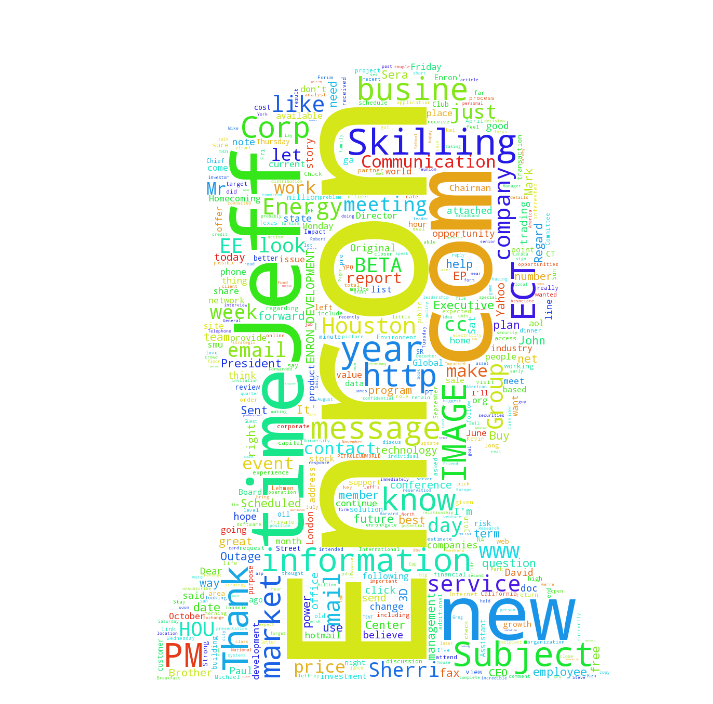

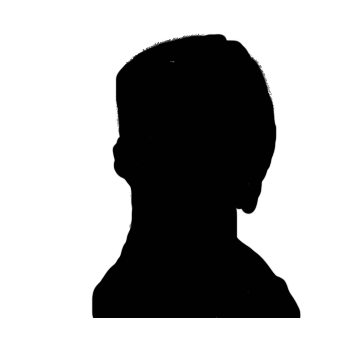

In [88]:

# store to file
wc.to_file(path.join(d, "skilling_j.png"))

# show
fig, ax = plt.subplots(figsize=(16, 12))
plt.imshow(wc)
plt.axis("off")
plt.figure()
plt.imshow(skilling_mask, cmap=plt.cm.gray)
plt.axis("off")
plt.show()

In [89]:
# lay-k

In [91]:
lay_k = grouped_by_keypeople.ix['lay-k']
lay_k = ' '.join(lay_k)

In [94]:
__file__ =  '/Users/Lucinda/Desktop/'
d = path.dirname(__file__)

lay_mask = imread(path.join(d, "/Users/Lucinda/Desktop/Image001.jpg"))

In [95]:
wc = wordcloud.WordCloud(width=800, 
                         background_color = 'white',
                         height=600, 
                         max_words=500,
                         mask = lay_mask,
                         stopwords=ENGLISH_STOP_WORDS).generate(lay_k)


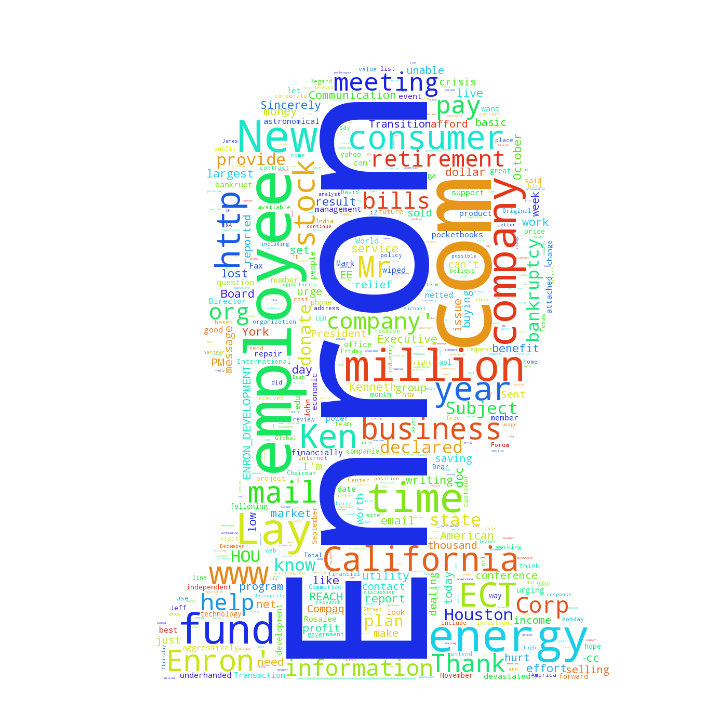

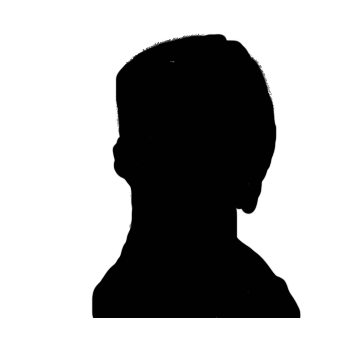

In [96]:
# store to file
wc.to_file(path.join(d, "lay_k.png"))

# show
fig, ax = plt.subplots(figsize=(16, 12))
plt.imshow(wc)
plt.axis("off")
plt.figure()
plt.imshow(lay_mask, cmap=plt.cm.gray)
plt.axis("off")
plt.show()

In [380]:
mann_k = ' '.join(mann_k)

In [430]:
__file__ =  '/Users/Lucinda/Desktop/'
d = path.dirname(__file__)

Mann_mask = imread(path.join(d, "/Users/Lucinda/Desktop/Kay3.png"))

In [431]:
wc = wordcloud.WordCloud(width=800, 
                         background_color = 'white',
                         height=600, 
                         max_words=500,
                         mask = Mann_mask,
                         stopwords=ENGLISH_STOP_WORDS).generate(mann_k)


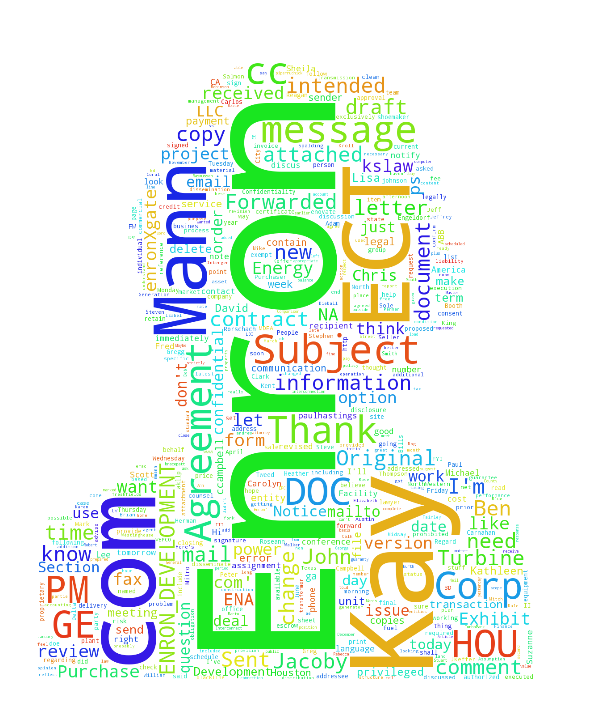

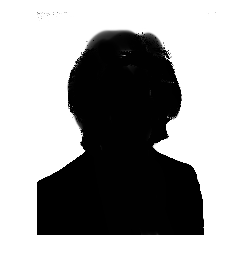

In [432]:

# store to file
wc.to_file(path.join(d, "Mann_mask.png"))

# show
fig, ax = plt.subplots(figsize=(16, 12))
plt.imshow(wc)
plt.axis("off")
plt.figure()
plt.imshow(Mann_mask, cmap=plt.cm.gray)
plt.axis("off")
plt.show()

### Sara

In [72]:
for each in index_list:
    if each[0]=='s':
        #print(each)

SyntaxError: unexpected EOF while parsing (<ipython-input-72-e1a654bf659e>, line 3)

In [405]:
sara_s = grouped_by_keypeople.ix['shackleton-s']

In [406]:
sara_s = ' '.join(sara_s)

In [420]:
__file__ =  '/Users/Lucinda/Desktop/'
d = path.dirname(__file__)

Sara_mask = imread(path.join(d, "/Users/Lucinda/Desktop/Sara3.jpg"))

In [421]:
wc = wordcloud.WordCloud(width=800, 
                         background_color = 'white',
                         height=600, 
                         max_words=500,
                         mask = Sara_mask,
                         stopwords=ENGLISH_STOP_WORDS).generate(sara_s)

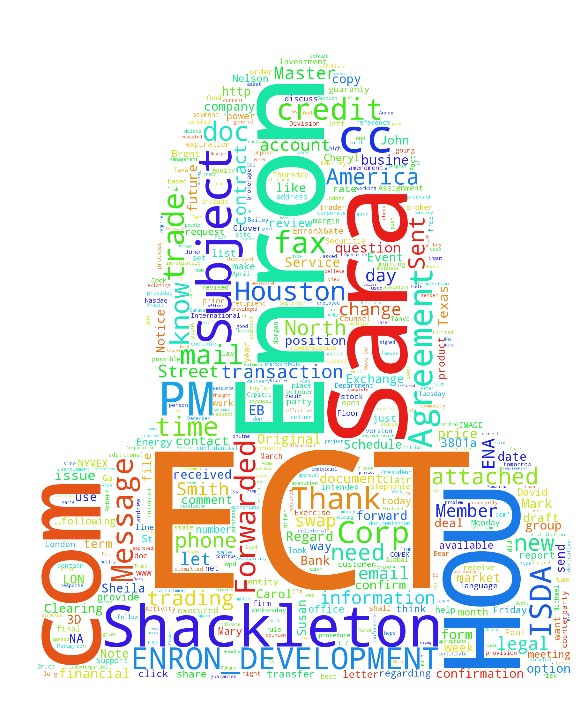

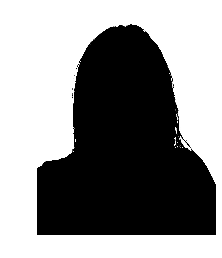

In [422]:

# store to file
wc.to_file(path.join(d, "Sara_mask.png"))

# show
fig, ax = plt.subplots(figsize=(16, 12))
plt.imshow(wc)
plt.axis("off")
plt.figure()
plt.imshow(Sara_mask, cmap=plt.cm.gray)
plt.axis("off")
plt.show()

#### jones

In [425]:
jones_t= grouped_by_keypeople.ix['jones-t']

In [426]:
jones_t = ' '.join(jones_t)

In [427]:
__file__ =  '/Users/Lucinda/Desktop/'
d = path.dirname(__file__)

Jones_mask = imread(path.join(d, "/Users/Lucinda/Desktop/Jone2.png"))

In [428]:
wc = wordcloud.WordCloud(width=800, 
                         background_color = 'white',
                         height=600, 
                         max_words=500,
                         mask = Jones_mask,
                         stopwords=ENGLISH_STOP_WORDS).generate(jones_t)

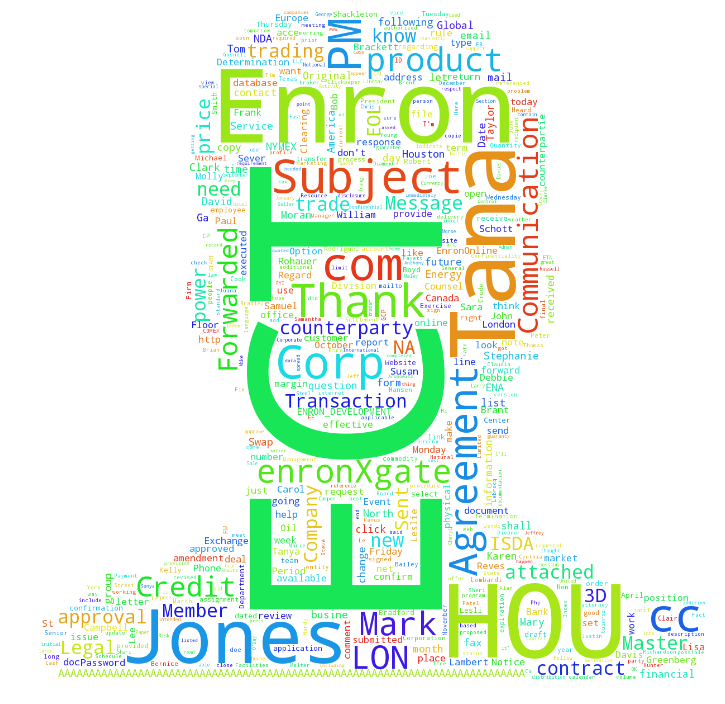

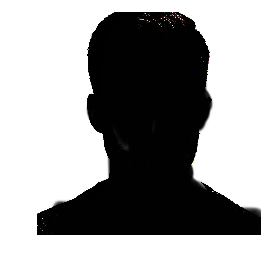

In [429]:

# store to file
wc.to_file(path.join(d, "Jones_mask.png"))

# show
fig, ax = plt.subplots(figsize=(16, 12))
plt.imshow(wc)
plt.axis("off")
plt.figure()
plt.imshow(Jones_mask, cmap=plt.cm.gray)
plt.axis("off")
plt.show()

In [245]:
#sns.pairplot(grouped_by_people.reset_index(), hue='user')

In [167]:
def replace_all(eg):
    rep = {"(":"",
       ")":"",
      "{":"",
      "}":"",
      "'":"",
        '"':"",
      "frozenset":""}
    for i,j in rep.items():
        eg = eg.replace(i,j)
    return eg

emails_df['Subject'] = emails_df['Subject'].apply(lambda x : replace_all(str(x)))

In [168]:
subjects = ' '.join(emails_df['Subject'])

In [76]:

'''fig, ax = plt.subplots(figsize=(16, 12))
wc = wordcloud.WordCloud(width=800, 
                         height=600, 
                         max_words=200,
                         stopwords=ENGLISH_STOP_WORDS).generate(subjects)
ax.imshow(wc)
ax.axis("off")'''

'fig, ax = plt.subplots(figsize=(16, 12))\nwc = wordcloud.WordCloud(width=800, \n                         height=600, \n                         max_words=200,\n                         stopwords=ENGLISH_STOP_WORDS).generate(subjects)\nax.imshow(wc)\nax.axis("off")'

(0.0, 1.0, 0.0, 1.0)

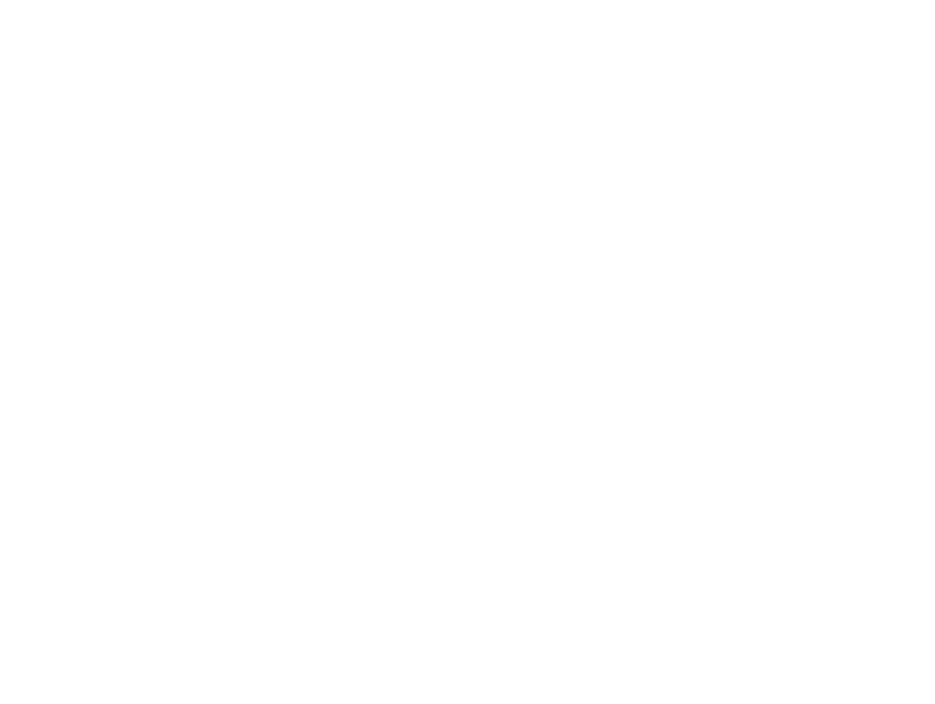

In [115]:
contents = ' '.join(emails_df['content'])
fig, ax = plt.subplots(figsize=(16, 12))
wc = wordcloud.WordCloud(width=800, 
                         height=600, 
                         max_words=200,
                         stopwords=ENGLISH_STOP_WORDS).generate(contents)
ax.imshow(wc)
ax.axis("off")

In [189]:

# Read the whole text.
Text = ' '.join(unique_words_df['Words'])

In [242]:
from os import path
from scipy.misc import imread
#import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS

__file__ =  '/Users/Lucinda/Desktop/'
d = path.dirname(__file__)



# read the mask image
# taken from
# http://www.stencilry.org/stencils/movies/alice%20in%20wonderland/255fk.jpg
Enron_mask = imread(path.join(d, "/Users/Lucinda/Desktop/EnronF2.png"))
#Enron_mask = Enron_mask.resize((980,1080), Image.ANTIALIAS) 

# generate word cloud
wc = wordcloud.WordCloud(background_color= 'white',
                         width=1200, 
                         height=900, 
                         max_words=3500,
                         mask=Enron_mask,
                         stopwords=ENGLISH_STOP_WORDS)
wc.generate(Text)


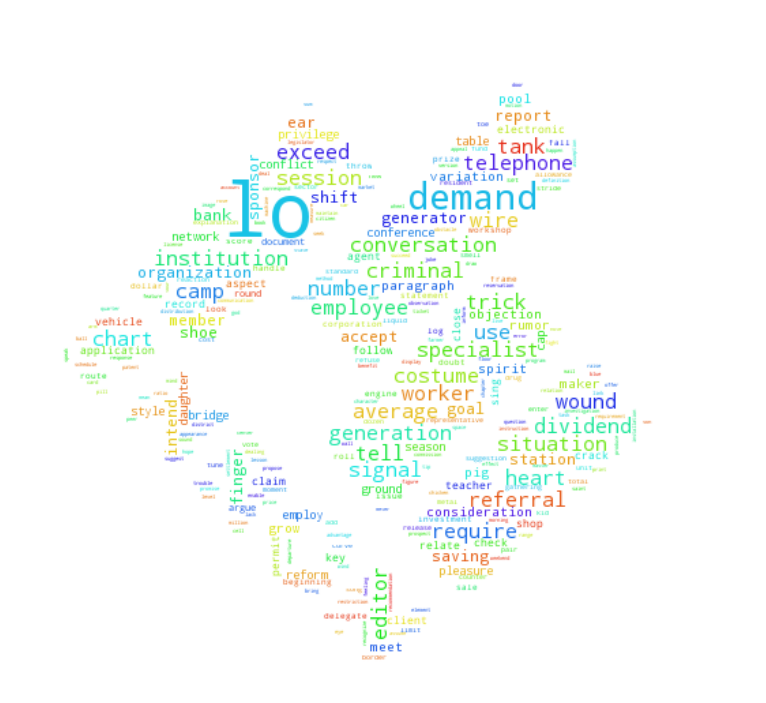

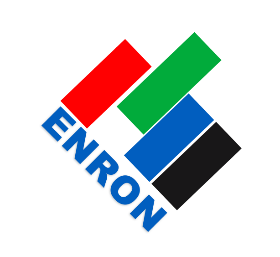

In [244]:

# store to file
wc.to_file(path.join(d, "enron1.png"))

# show
fig, ax = plt.subplots(figsize=(16, 12))
plt.imshow(wc)
plt.axis("off")
plt.figure()
plt.imshow(Enron_mask, cmap=plt.cm.gray)
plt.axis("off")
plt.show()

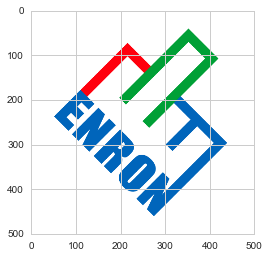

In [178]:
plt.imshow(Enron_mask, cmap=plt.cm.gray)